In [13]:
from pathlib import Path
import os
import ngauge
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import pandas as pd

from brainlit.map_neurons.map_neurons import (
    Diffeomorphism_Transform,
)
from brainlit.map_neurons.utils import replace_root

In [14]:
root_dir = Path(os.path.abspath(""))
data_dir = Path(os.path.join(root_dir, "data"))

Computing transformed derivatives...: 100%|██████████| 7350/7350 [00:14<00:00, 523.40it/s]


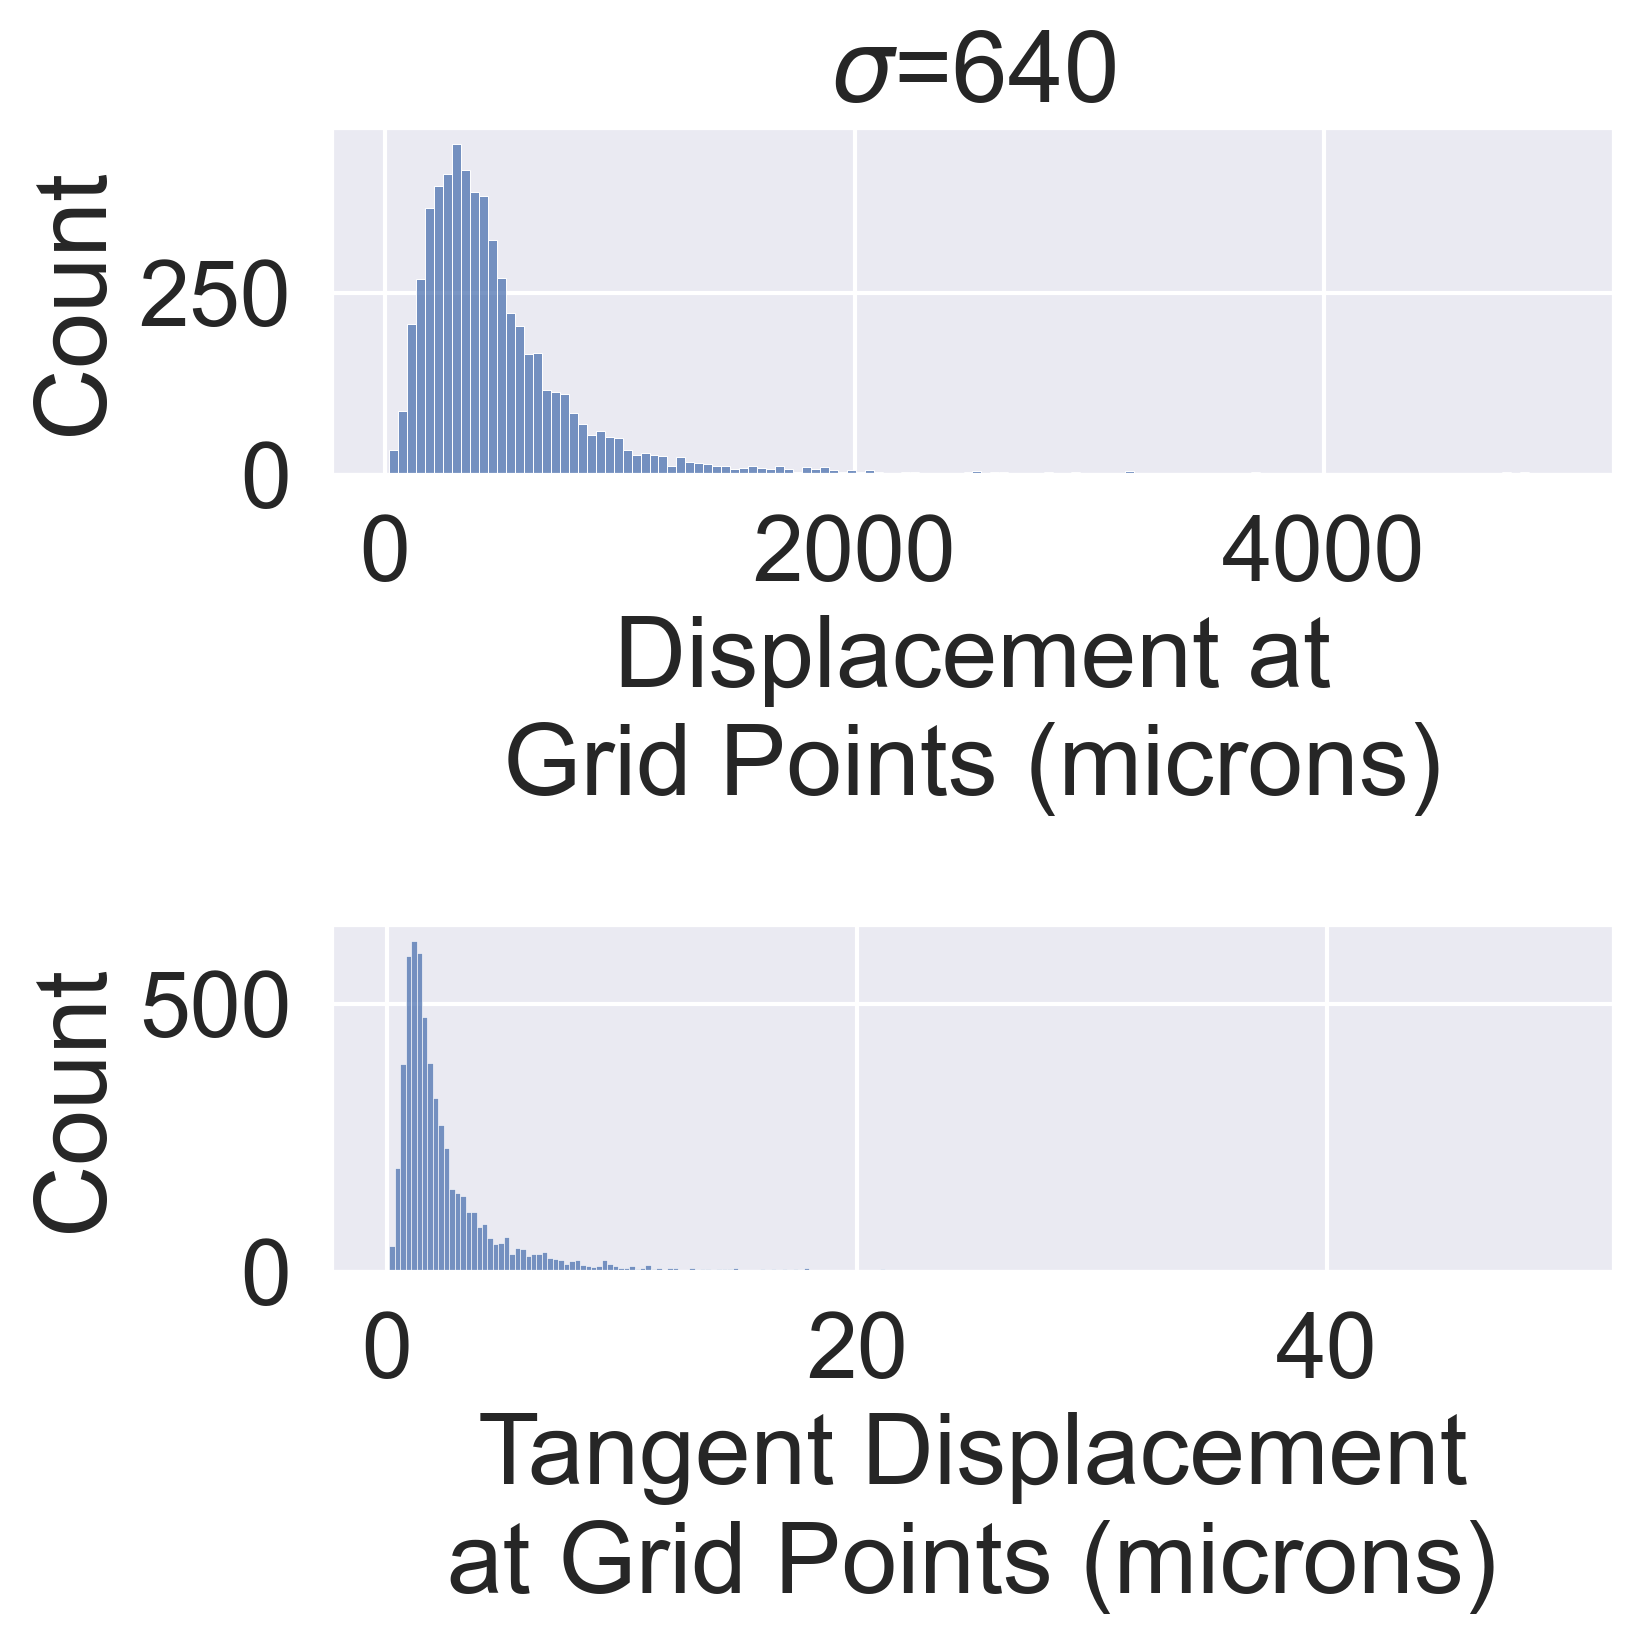

In [16]:
sns.set(font_scale=2)
fig, axs = plt.subplots(2, 1, figsize=(6, 6), dpi=300)
sigma = 320

fname = data_dir / f"exp-morpho-diffeo-{sigma}.pickle"
with open(fname, "rb") as f:
    data = pickle.load(f)
xv = data["xv"]
phii = data["phii"]
ct = Diffeomorphism_Transform(xv, phii)

og_coords = ct.og_coords
xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

gap = 500
xs = np.arange(xmin + gap, xmax - gap, gap)
ys = np.arange(ymin + gap, ymax - gap, gap)
zs = np.arange(zmin + gap, zmax - gap, gap)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)
new_derivs = ct.D(og_coords, np.ones(og_coords.shape), verbose=True)

position_diff = np.linalg.norm(og_coords - new_coords, axis=1)
deriv_diff = np.linalg.norm(np.ones(og_coords.shape) - new_derivs, axis=1)
data = {
    "Displacement at\nGrid Points (microns)": position_diff,
    "Tangent Displacement\nat Grid Points (microns)": deriv_diff,
}

df = pd.DataFrame(data=data)
df_filter = df[df["Displacement at\nGrid Points (microns)"] < 5000]
sns.histplot(data=df_filter, ax=axs[0], x="Displacement at\nGrid Points (microns)")
df_filter = df[df["Tangent Displacement\nat Grid Points (microns)"] < 50]
sns.histplot(
    data=df_filter, ax=axs[1], x="Tangent Displacement\nat Grid Points (microns)"
)

axs[0].set_title(rf"$\sigma$={2*int(sigma)}")

plt.tight_layout()

# Show neuron mappings

In [4]:
def check_duplicates_center(neuron):
    assert len(neuron.branches) == 1

    stack = []
    stack += neuron.branches[0]
    coords = []

    while len(stack) > 0:
        child = stack.pop()
        stack += child.children
        coords.append([child.x, child.y, child.z])

    # look for duplicates
    dupes = []
    seen = set()
    for coord in coords:
        coord = tuple(coord)
        if coord in seen:
            dupes.append(coord)
        else:
            seen.add(coord)

    # center coordinates
    if len(dupes) > 0:
        raise ValueError(f"Duplicate nodes")
    else:
        coords = np.array(coords)
        mx = np.amax(coords, axis=0)
        mn = np.amin(coords, axis=0)
        center = np.mean(np.array([mx, mn]), axis=0)
        stack = [neuron.branches[0]]

        while len(stack) > 0:
            child = stack.pop()
            stack += child.children

            child.x -= center[0]
            child.y -= center[1]
            child.z -= center[2]

    return neuron


def plot_neuron(neuron, ax, color, label, limits=None, ax2=None, center=False):
    neuron = replace_root(neuron)
    if center:
        neuron = check_duplicates_center(neuron)

    stack = []
    stack += neuron.branches[0]

    coords = []
    first1 = True
    first2 = True
    with tqdm(total=neuron.total_child_nodes()) as pbar:
        while stack:
            node = stack.pop()
            stack += node.children

            pbar.update(1)

            coords.append([node.x, node.y, node.z])
            for child in node.children:
                if first1:
                    first1 = False
                    ax.plot(
                        [node.x, child.x],
                        [node.y, child.y],
                        [node.z, child.z],
                        c=color,
                        linewidth=1,
                        label=label,
                    )
                else:
                    ax.plot(
                        [node.x, child.x],
                        [node.y, child.y],
                        [node.z, child.z],
                        c=color,
                        linewidth=1,
                    )

                if limits is not None:
                    xmin, ymin, zmin = limits[0]
                    xmax, ymax, zmax = limits[1]

                    if (
                        node.x < xmin
                        or node.x > xmax
                        or node.y < ymin
                        or node.y > ymax
                        or node.z < zmin
                        or node.z > zmax
                    ):
                        continue
                    else:
                        for child in node.children:
                            if first2:
                                first2 = False
                                ax2.plot(
                                    [node.x, child.x],
                                    [node.y, child.y],
                                    [node.z, child.z],
                                    c=color,
                                    linewidth=1,
                                    alpha=0.5,
                                    label=label,
                                )
                            else:
                                ax2.plot(
                                    [node.x, child.x],
                                    [node.y, child.y],
                                    [node.z, child.z],
                                    c=color,
                                    linewidth=1,
                                    alpha=0.5,
                                )
                                # ax2.scatter([node.x], [node.y], [node.z], c="blue", linewidth=1, alpha=0.5)

    return ax, ax2, coords

100%|█████████▉| 14667/14668 [00:29<00:00, 503.32it/s]


<matplotlib.legend.Legend object at 0x1979d71c0>

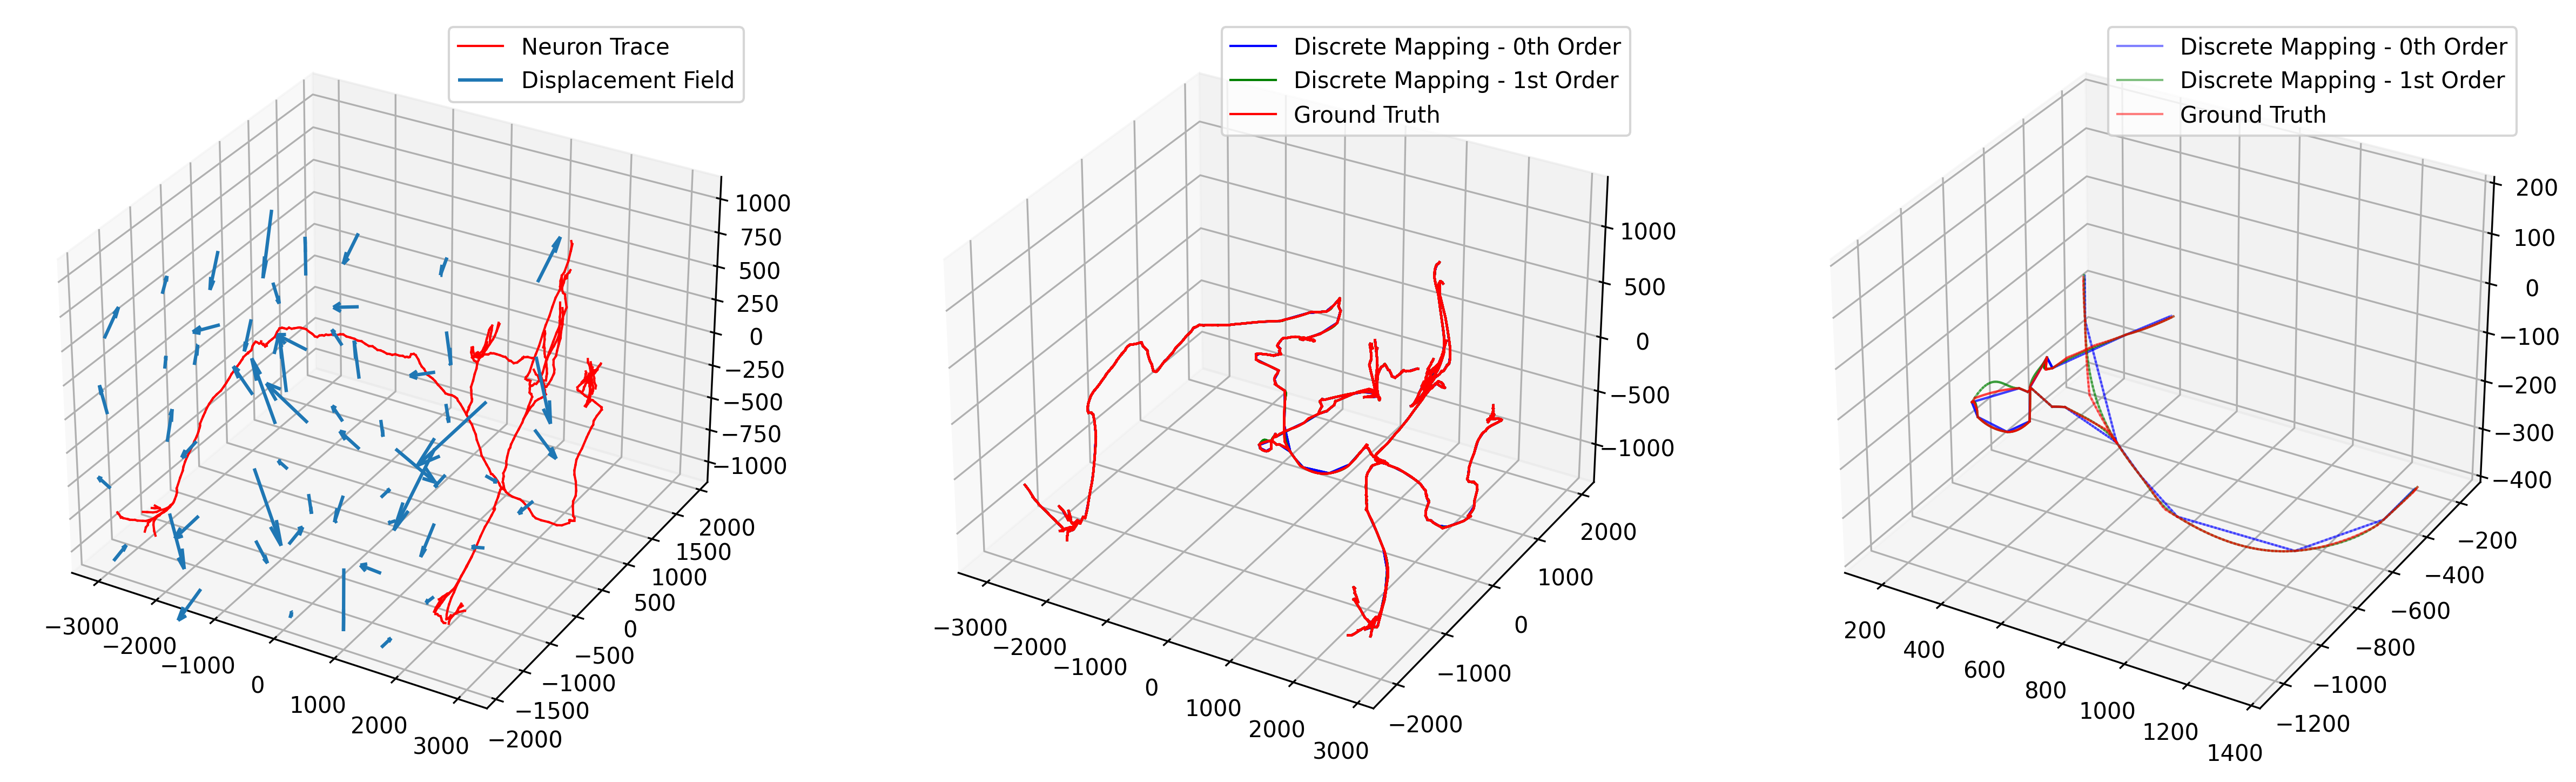

In [7]:
sample = "AA1093"

fig = plt.figure(figsize=(20, 10), dpi=300)
ax0 = fig.add_subplot(1, 3, 1, projection="3d")
ax1 = fig.add_subplot(1, 3, 2, projection="3d")
ax2 = fig.add_subplot(1, 3, 3, projection="3d")


fname = data_dir / f"{sample}.swc"
neuron = ngauge.Neuron.from_swc(fname)

ax0, _, coords = plot_neuron(
    neuron, ax=ax0, color="red", label="Neuron Trace", center=True
)

fname = data_dir / f"exp-morpho-diffeo-320.pickle"
with open(fname, "rb") as f:
    data = pickle.load(f)
xv = data["xv"]
phii = data["phii"]
ct = Diffeomorphism_Transform(xv, phii)

coords = np.array(coords)
mn = np.amin(coords, axis=0)
mx = np.amax(coords, axis=0)

xmin, ymin, zmin = mn[0], mn[1], mn[2]
xmax, ymax, zmax = mx[0], mx[1], mx[2]

xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

idxs2remove = []
for i, coord in enumerate(og_coords):
    if np.linalg.norm(coord - new_coords[i, :]) > 1000:
        idxs2remove.append(i)

og_coords = np.delete(og_coords, idxs2remove, axis=0)
new_coords = np.delete(new_coords, idxs2remove, axis=0)

ax0.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    new_coords[:, 0] - og_coords[:, 0],
    new_coords[:, 1] - og_coords[:, 1],
    new_coords[:, 2] - og_coords[:, 2],
    # length=2,
    label="Displacement Field",
    # alpha=0.5,
)

# TRANSFORMED
if sample == "AA1093":
    xmin, xmax = 0, 1500
    ymin, ymax = -1400, 0
    zmin, zmax = -500, 200

else:
    xmin, xmax = -2700, -1800
    ymin, ymax = -2000, 2000
    zmin, zmax = 500, 800


fname = data_dir / f"{sample}-sig-320-0.swc"
neuron = ngauge.Neuron.from_swc(fname)
ax1, ax2, _ = plot_neuron(
    neuron,
    ax1,
    color="blue",
    label="Discrete Mapping - 0th Order",
    limits=[(xmin, ymin, zmin), (xmax, ymax, zmax)],
    ax2=ax2,
)


fname = data_dir / f"{sample}-sig-320-1.swc"
neuron = ngauge.Neuron.from_swc(fname)
ax1, ax2, _ = plot_neuron(
    neuron,
    ax1,
    color="green",
    label="Discrete Mapping - 1st Order",
    limits=[(xmin, ymin, zmin), (xmax, ymax, zmax)],
    ax2=ax2,
)


fname = data_dir / f"{sample}-sig-320-gt.swc"
neuron = ngauge.Neuron.from_swc(fname)
ax1, ax2, _ = plot_neuron(
    neuron,
    ax1,
    color="red",
    label="Ground Truth",
    limits=[(xmin, ymin, zmin), (xmax, ymax, zmax)],
    ax2=ax2,
)

ax2.set_xlim(xmin + 100, xmax - 100)
ax2.set_ylim(ymin + 100, ymax - 100)
ax2.set_zlim(zmin + 100, zmax)

ax0.legend()
ax1.legend()
ax2.legend()